# Diferentes técnicas de balanceamiento de datos

Los objetivos de este fichero son:

- Aplicar diferentes métodos de balanceamiento al dataset proporcionado
- Ver como afectan los cambios
- Escoger un método

Aunque al final de este fichero se guarde un dataset balanceado no quiere decir que sea el único que se vaya a usar ahora en adelante, ya que dependiendo del modelo elegido en próximos notebooks como el de la segunda entrega requerira un tipo de dataset o otro, o varios para diferentes niveles del modelo.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np

from scipy.stats import uniform, randint

%matplotlib inline

from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler,ADASYN,SVMSMOTE,BorderlineSMOTE
from imblearn.under_sampling import ClusterCentroids,InstanceHardnessThreshold,NearMiss,AllKNN, RandomUnderSampler,OneSidedSelection,NeighbourhoodCleaningRule,CondensedNearestNeighbour
from imblearn.combine import SMOTEENN,SMOTETomek
#from imblearn.ensemble import BalanceCascade

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler


import sys; sys.path.insert(0, '..')
import lib

import xgboost as xgb

## Load data

In [2]:
X, y = lib.readHDF('../../Data/raw/hdf5/data.hdf5')
X.drop(['ID','X','Y'], axis=1, inplace=True)
X.head()
X = lib.buildingFloorToNumeric(X)
X = lib.cadastralQualityToNumeric(X)

## Nivel de desbalanceamiento

In [3]:
count_classes = y.value_counts(sort = True)
print(count_classes)

RESIDENTIAL    90173
INDUSTRIAL      4490
PUBLIC          2976
RETAIL          2093
OFFICE          1828
OTHER           1332
AGRICULTURE      338
Name: CLASE, dtype: int64


## Split train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

## Helper functions

In [5]:
def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,y_resampled = transformer.fit_sample(X.values,y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

## Apply transformations to dataset

In [6]:
datasets = []
datasets.append(("base",X_train,y_train))

### Over

In [7]:
datasets.append(transform(SMOTE(n_jobs=12),X_train,y_train))
#datasets.append(transform(RandomOverSampler(),X_train,y_train))   
#datasets.append(transform(SVMSMOTE(n_jobs=12),X_train,y_train))    
#datasets.append(transform(ADASYN(n_jobs=12),X_train,y_train))
#datasets.append(transform(BorderlineSMOTE(n_jobs=12),X_train,y_train))

Transforming SMOTE


### Under

In [ ]:
#datasets.append(transform(InstanceHardnessThreshold(n_jobs=12),X_train,y_train))
#datasets.append(transform(OneSidedSelection(n_neighbors=5, n_seeds_S=200,n_jobs=12),X_train,y_train))
#datasets.append(transform(ClusterCentroids(n_jobs=12),X_train,y_train))
#datasets.append(transform(NearMiss(n_jobs=12),X_train,y_train))
#datasets.append(transform(RandomUnderSampler(),X_train,y_train))
#datasets.append(transform(NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5,n_jobs=12),X_train,y_train))
#datasets.append(transform(CondensedNearestNeighbour(n_neighbors=3,n_jobs=12),X_train,y_train))

### Combine

In [8]:
count_classes = y_train.value_counts()
print(count_classes)

RESIDENTIAL    72169
INDUSTRIAL      3558
PUBLIC          2386
RETAIL          1692
OFFICE          1454
OTHER           1057
AGRICULTURE      268
Name: CLASE, dtype: int64


El diccionario de abajo es para probar la técnica de SMOTE con un balanceamiento de en vez 1:1 con la cantidad de observaciones que expresa el diccionario.

Se ha hecho de forma que se asemeje más a la distribución del Estimar dataset permitiendo distinguir mejor clases minoritarias

In [9]:
over_dict = {
    "RESIDENTIAL": count_classes['RESIDENTIAL'],
    "INDUSTRIAL":count_classes[ "INDUSTRIAL"] * 3 ,
    "PUBLIC":count_classes["PUBLIC"] * 4,
    "RETAIL":count_classes["RETAIL"] * 5,
    "OFFICE":count_classes["OFFICE"] * 5,
    "OTHER":count_classes["OTHER"] * 6,
    "AGRICULTURE": count_classes["AGRICULTURE"] * 8
}
over_dict

{'RESIDENTIAL': 72169,
 'INDUSTRIAL': 10674,
 'PUBLIC': 9544,
 'RETAIL': 8460,
 'OFFICE': 7270,
 'OTHER': 6342,
 'AGRICULTURE': 2144}

In [10]:
datasets.append(transform(SMOTEENN(),X_train,y_train))
datasets.append(transform(SMOTETomek(),X_train,y_train))

#tmp_transformer = SMOTE(sampling_strategy=over_dict)
#X_tmp, y_tmp = tmp_transformer.fit_sample(X_train.values,y_train.values.ravel())
tmp = transform(SMOTE(sampling_strategy=over_dict),X_train,y_train)
datasets.append(('SMOTE_Personalizado',tmp[1],tmp[2]))

Transforming SMOTETomek
Transforming SMOTE


In [11]:
#tmp = transform(AllKNN(n_jobs=12,n_neighbors=1),X_train,y_train)
'''count_classes = tmp[2].iloc[:,0].value_counts()
print(count_classes)
over_dict = {
    "RESIDENTIAL": count_classes['RESIDENTIAL'],
    "INDUSTRIAL":count_classes[ "INDUSTRIAL"] * 10 ,
    "PUBLIC":count_classes["PUBLIC"] * 16,
    "RETAIL":count_classes["RETAIL"] * 20,
    "OFFICE":count_classes["OFFICE"] * 21,
    "OTHER":count_classes["OTHER"] * 22,
    "AGRICULTURE": count_classes["AGRICULTURE"] * 26
}
print(over_dict)
'''
#tmp = transform(SMOTE(sampling_strategy=over_dict),tmp[1],tmp[2])
#datasets.append(('SMOTE_OSS_Personalizado',tmp[1],tmp[2]))

RESIDENTIAL    72169
INDUSTRIAL     10674
PUBLIC          9544
RETAIL          8460
OFFICE          7270
OTHER           6342
AGRICULTURE     2144
Name: 0, dtype: int64
{'RESIDENTIAL': 72169, 'INDUSTRIAL': 106740, 'PUBLIC': 152704, 'RETAIL': 169200, 'OFFICE': 152670, 'OTHER': 139524, 'AGRICULTURE': 55744}


## Evaluar modelos para cada transformación

Para cada dataset se entrena y evalua un modelo creado con XGBoost con los valores por defecto para hacernos una idea de como afectan los cambios realizados

In [12]:
scores = []

for s_type,X,y in datasets:
    model = xgb.XGBClassifier(random_state=1,tree_method='gpu_hist', gpu_id=0,objective="multi:softmax")
    %time model.fit(X.values,y.values.ravel())
    pred_test = model.predict(X_test.values)
    scores.append((s_type,
        f1_score(y_test.values.ravel(),pred_test,average='macro'),
        precision_score(y_test.values.ravel(),pred_test,average='micro'),
        recall_score(y_test.values.ravel(),pred_test,average='micro'),
        accuracy_score(y_test.values.ravel(),pred_test),
        confusion_matrix(y_test.values.ravel(),pred_test)
    ))

Wall time: 14.3 s
Wall time: 24.2 s
Wall time: 23.8 s
Wall time: 15.2 s


In [13]:
sampling_results = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','confusion_matrix'])
sampling_results.sort_values('accuracy',inplace=True,ascending=False)
sampling_results

,Sampling Type,f1,precision,recall,accuracy,confusion_matrix
0,base,0.501847,0.910636,0.910636,0.910636,"[[44, 7, 0, 0, 4, 14, 1], [4, 579, 23, 12, 27,..."
3,SMOTE_Personalizado,0.515747,0.908747,0.908747,0.908747,"[[47, 7, 1, 0, 4, 10, 1], [5, 561, 36, 24, 30,..."
1,SMOTE,0.505018,0.885498,0.885498,0.885498,"[[53, 7, 2, 0, 4, 4, 0], [9, 585, 48, 24, 42, ..."
2,SMOTETomek,0.496817,0.879977,0.879977,0.879977,"[[53, 8, 1, 2, 3, 3, 0], [10, 586, 52, 32, 38,..."


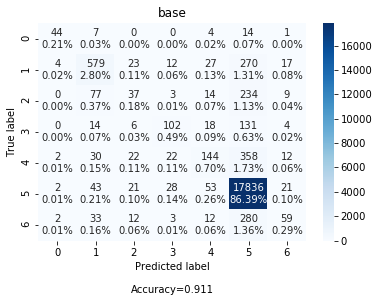

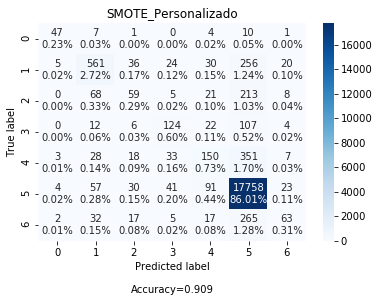

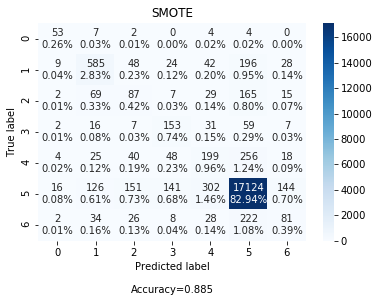

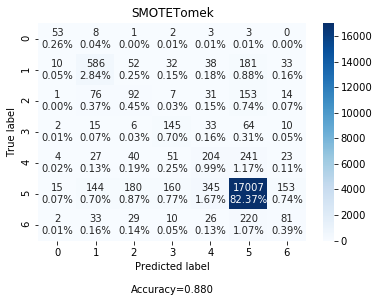

In [14]:
for index, row in sampling_results.iterrows():
    lib.make_confusion_matrix(row['confusion_matrix'],title = row['Sampling Type'])

### Nivel de balanceamiento

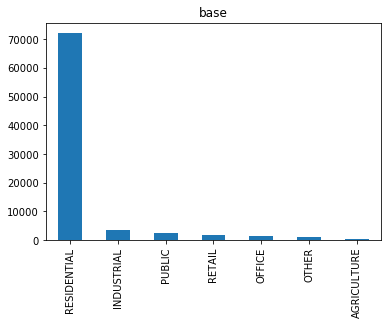

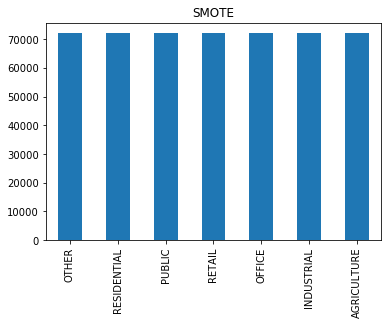

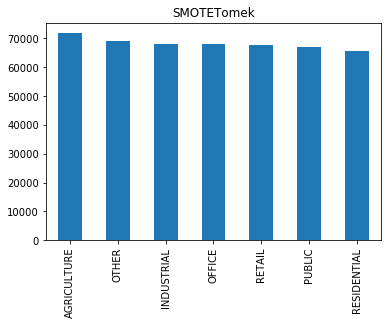

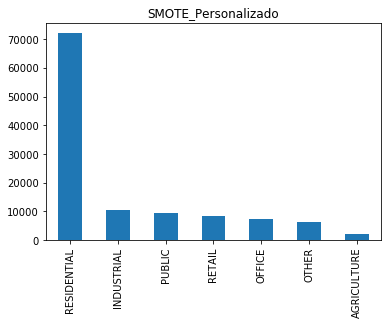

In [15]:
for name, x, y in datasets:
    y.squeeze().value_counts().plot(kind='bar', title=name)
    plt.show()

### Guardar datos balanceados por el método elegido

{'RESIDENTIAL': 90173, 'INDUSTRIAL': 13470, 'PUBLIC': 11904, 'RETAIL': 10465, 'OFFICE': 9140, 'OTHER': 7992, 'AGRICULTURE': 2704}
Transforming SMOTE


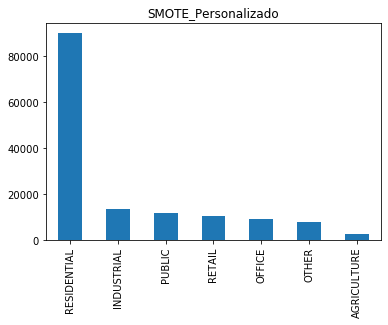

In [395]:
# Applicar el metodo elegido a todos los datos y guardar
count_classes = y.value_counts()
over_dict = {
    "RESIDENTIAL": count_classes['RESIDENTIAL'],
    "INDUSTRIAL":count_classes[ "INDUSTRIAL"] * 3 ,
    "PUBLIC":count_classes["PUBLIC"] * 4,
    "RETAIL":count_classes["RETAIL"] * 5,
    "OFFICE":count_classes["OFFICE"] * 5,
    "OTHER":count_classes["OTHER"] * 6,
    "AGRICULTURE": count_classes["AGRICULTURE"] * 8
}
print(over_dict)
datasets = []
tmp = transform(SMOTE(sampling_strategy=over_dict),X,y)
datasets.append(('SMOTE_Personalizado',tmp[1],tmp[2]))

for name, x, y in datasets:
    y.squeeze().value_counts().plot(kind='bar', title=name)
    plt.show()
    
    
path = '../../Data/balanced/'
for s_type,X,y in datasets:
    lib.storeHDF(path+s_type+'.hdf5',X_train=X,y_train=y)

## Balanceamiento actual


In [399]:
count_classes = datasets[0][2].iloc[:,0].value_counts()
count_classes

RESIDENTIAL    90173
INDUSTRIAL     13470
PUBLIC         11904
RETAIL         10465
OFFICE          9140
OTHER           7992
AGRICULTURE     2704
Name: 0, dtype: int64